# WhatsApp Chat History Data Visualization

*Disclaimer: This is a work-in-progress notebook for prototyping my chat log data visualization tool. Code here has been minimally refactored / vectorized / optimized and therefore has plenty of scope for improvement!*

### Imports

Let's start off by importing our bread-and-butter data and visualization libraries:

In [144]:
import os.path

In [145]:
# Data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

We will also import the custom dictionaries defined in `Chat-History-Custom-Functs.ipynb` (which will be used in the text normalization process). Feel free to edit the dictionaries based on the desired normalization in your text.

In [146]:
%run Chat-History-User-Defined.ipynb

### Data Extraction

We'll read in the WhatsApp chat log (exported from an iOS device) to a dataframe and make a deepcopy for us to try out all of our preprocessing on. <br>
**Note:** For privacy purposes, the chat log available on GitHub is much shorter and consists of dummy text, albeit maintaining WhatsApp's export style

In [147]:
# Read in Whatsapp chat log to a dataframe

imported_messages = pd.read_csv('chat.txt', delimiter='\n', skiprows=[0], names = ['text_raw'])
imported_messages.head()

,text_raw
0,"[2020-02-28, 2:55:53 AM] User 1: From outside ..."
1,"[2020-02-28, 2:55:53 AM] User 2: and lool lool..."
2,"[2020-02-28, 2:56:07 AM] User 2: \ which told ..."
3,"[2020-02-28, 2:56:08 AM] User 2: hah lmaoooo w..."
4,"[2020-02-28, 2:56:27 AM] User 1: 😯 Far away we..."


In [148]:
imported_messages.tail()

,text_raw
29,"[2020-03-08, 05:20:32 PM] User 2: At the momen..."
30,"[2020-03-08, 05:45:56 PM] User 1: lool but the..."
31,made it impossible for me to tell what it was ...
32,"[2020-03-08, 05:50:34 PM] User 2: I could, how..."
33,"[2020-03-08, 05:52:12 PM] User 2: https://towa..."


**Note:** Using '\n' as the delimiter results in messages with embedded line breaks escaping to new rows in the dataframe. These rows will not have the '*\[datetime\] username: text*' pattern seen in other rows, so we need to handle these appropriately when separating out datetimes and usernames.

In [149]:
# Deepcopy into a working dataframe for preprocessing / cleaning

messages = imported_messages.copy(deep=True)
messages.iloc[7:11]

,text_raw
7,"[2020-02-29, 6:00:23 PM] User 1: ☺ Twelve struck,"
8,"and one and two and three,"
9,and still we sat waiting silently for whatever...
10,"[2020-02-29, 6:15:12 PM] User 1: ‎video omitted"


### Preprocessing Non-Text Data

Alright, now let's work on extracting the datetime and username fields by leveraging [regular expressions](https://jakevdp.github.io/WhirlwindTourOfPython/14-strings-and-regular-expressions.html). Let's start with some useful libraries.

In [150]:
# Libraries to help us handle dates/times
import datetime as dt
from pytz import timezone
from dateutil.relativedelta import relativedelta

# Library for regular expressions
import regex

# Library to handle emojis in text
import emoji

We'll define a helper function to aid us with extracting usernames and datetimes, then apply it to our dataframe. Here is further reading on [Regex Match Objects](https://docs.python.org/2.0/lib/match-objects.html) and [Python string splitting](https://docs.python.org/3/library/stdtypes.html#str.split).

In [151]:
# Function to extract datetime and username as text
def extract_datetime_username(text):
    """
    Note:   Requires regex module to be imported
    Input:  String of text which may contain '[...]' text pattern
            Eg: "[2018-12-21, 2:55:51 AM] User 1: Messages to this chat and calls are now secured with end-to-end encryption."
            
    Output: Tuple of EITHER: (String to the right of the ': ' text pattern      Eg. "Messages to this chat and calls are now secured with end-to-end encryption."
                              String with contents of the '[...]' text pattern  Eg. "2018-12-21, 2:55:51 AM", 
                              String between the '[...]' and ': ' text patterns Eg. "User 1" )
                              
                     OR:     (String of of the original text if ''[...]'' pattern is not found,
                              NaN,
                              NaN)
    """
    # Regex to find '[...]' pattern in text. date_time is a Regex Match Object
    date_time = regex.search(r'.*\[(.*)\].*', text)
    
    # Output based on pattern search result
    if date_time:
        # Since we want to split only on the first occurrence of "] " and ": " respectively, we pass in maxsplit=1 on str.split()
        text_no_date = text.split("] ", maxsplit=1)[1]
        text_split_on_user = text_no_date.split(": ", maxsplit=1)
        return (text_split_on_user[1], date_time.group(1), text_split_on_user[0])
    else:
        return (text, np.nan, np.nan)

In [152]:
# Apply the function to our dataframe and extract out the datetimes and usernames
messages['text_raw'], messages['date_time'], messages['username'] = zip(*messages['text_raw'].apply(extract_datetime_username))
messages.head()

,text_raw,date_time,username
0,From outside came the occasional cry of a nigh...,"2020-02-28, 2:55:53 AM",User 1
1,and lool lool lool lool once at our very windo...,"2020-02-28, 2:55:53 AM",User 2
2,\ which told us that the cheetah was indeed at...,"2020-02-28, 2:56:07 AM",User 2
3,hah lmaoooo wooowww,"2020-02-28, 2:56:08 AM",User 2
4,😯 Far away we could hear the deep tones of the...,"2020-02-28, 2:56:27 AM",User 1


In [153]:
# Check to ensure functionality is as intended on rows with embedded line breaks
messages.iloc[7:11]

,text_raw,date_time,username
7,"☺ Twelve struck,","2020-02-29, 6:00:23 PM",User 1
8,"and one and two and three,",NaN,NaN
9,and still we sat waiting silently for whatever...,NaN,NaN
10,‎video omitted,"2020-02-29, 6:15:12 PM",User 1


Before we proceed, let's verify if there are any rows of text with none / NaN values.

In [154]:
messages[messages['text_raw'].isna()]

,text_raw,date_time,username


Now we can fill in the NaN values in the 'date_time' and 'username' columns by considering those messages to have been sent by the user in the row above, at the time in the row above.

In [155]:
messages.fillna(method='ffill', inplace=True)
messages.iloc[7:11]

,text_raw,date_time,username
7,"☺ Twelve struck,","2020-02-29, 6:00:23 PM",User 1
8,"and one and two and three,","2020-02-29, 6:00:23 PM",User 1
9,and still we sat waiting silently for whatever...,"2020-02-29, 6:00:23 PM",User 1
10,‎video omitted,"2020-02-29, 6:15:12 PM",User 1


Let's leverage Python's `datetime` module to convert our date_time column from a string to handy datetime objects (localized in my case to Toronto, Canada). <br>
**Note:** Runtime on this appears to be abysmal, but performs acceptably on a sub 100k record dataset. This is probably a good area to attempt optimization later (Do we need expensive datetime objects? Do we need to localize? Which of the two methods is the bottleneck? Is there a better function other than df.apply()?) 

In [156]:
LOCAL_TIMEZONE = timezone('America/Toronto')

In [157]:
messages['date_time'] = messages['date_time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d, %I:%M:%S %p'))
messages['date_time'] = messages['date_time'].apply(lambda x: LOCAL_TIMEZONE.localize(x))
messages.head()

,text_raw,date_time,username
0,From outside came the occasional cry of a nigh...,2020-02-28 02:55:53-05:00,User 1
1,and lool lool lool lool once at our very windo...,2020-02-28 02:55:53-05:00,User 2
2,\ which told us that the cheetah was indeed at...,2020-02-28 02:56:07-05:00,User 2
3,hah lmaoooo wooowww,2020-02-28 02:56:08-05:00,User 2
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1


### Preprocessing Text Data

Now we're ready to work directly on the text data and make it more palatable for extracting insights from. We'll begin with library imports - primarily from NLTK.

In [158]:
# Python String Library
import string

# NLTK for all our languarge processing needs (tokenization and stopword removal - lemmatization if our data ends up too 'muddy')
import nltk
#from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
#from nltk.stem import WordNetLemmatizer 
#from normalise import normalise

In [159]:
# If needed:
# nltk.download()

For reference, let's outline what our [text preprocessing](https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html) pipeline will look like. <br><br>
**Pipeline:**
1. Tokenize each message
2. Separate out emojis (**Note:** This might be revisited if/when I begin investigating sentiment analysis)                    
3. Categorize each message type (text / picture / video / link)
4. Clean text messages
5. Normalize user-specific slang in text messages
6. Remove stopwords from text messages

**Step 1:**<br>
Let's [tokenize](https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/) our corpus of text messages! In this case, we'll use NLTK's `TweetTokenizer`, since it is capable of splitting up emoji groupings and identifying html links as single tokens (see [here](https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7) for a brief comparison between NLTK tokenizers).

In [160]:
tokenizer = TweetTokenizer()
messages['text_processed'] = messages['text_raw'].apply(lambda x: tokenizer.tokenize(x))
messages.tail()

,text_raw,date_time,username,text_processed
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[At, the, moment, when, Holmes, struck, the, l..."
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl..."
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, it, impossible, for, me, to, tell, what..."
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[I, could, ,, however, ,, see, that, his, face..."
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...


**Step 2:** <br>
Let's now extract out the emojis from the text - through a helper function defined below. This will simplify the workload involved in extracting out emoji-related insights in our visualizations down the line. <br><br>
**Note:** I had originally modified a solution found [here](https://stackoverflow.com/questions/49113909/split-and-count-emojis-and-words-in-a-given-string-in-python?noredirect=1&lq=1) to create a (very un-optimized!) solution that extracted emojis directly from the un-tokenized messages. However, this was before I discovered the magic of `TweetTokenizer`!
[This site](https://www.regular-expressions.info/) and [this post](https://stackoverflow.com/questions/9928505/what-does-the-expression-x-match-when-inside-a-regex)  provided a lot of insight into understanding and using regex (despite it not being needed as heavily).

In [161]:
# Function for separating out emojis from the tokenized corpus
def extract_emojis(tokenlist):
    """
    Input:  List of tokenized strings (utf-8), containing emojis 
    Output: Tuple of the following: (list of non-emoji tokens from the input, list of all emoji tokens from the input)
    """
    
    
    list_emojis = []
    list_text = []
    
    list_emojis = [token for token in tokenlist if any(char in emoji.UNICODE_EMOJI for char in token)]
    list_text = [token for token in tokenlist if token not in list_emojis]
    
    return (list_text, list_emojis)

#   **For reference, here's the original emoji list creation code without the one-liner list comprehension
#    list_emojis = []
#    for token in tokenlist:
#        if any(char in emoji.UNICODE_EMOJI for char in token):  
#            list_emojis += [token]

In [162]:
# Apply it to our dataframe and extract out the emojis
messages['text_processed'], messages['emojis'] = zip(*messages['text_processed'].apply(extract_emojis))
messages.tail(10)

,text_raw,date_time,username,text_processed,emojis
24,"struck a match, and lashed furiously with his ...",2020-03-07 00:09:48-05:00,User 1,"[struck, a, match, ,, and, lashed, furiously, ...",[😆]
25,😯👀,2020-03-07 00:09:56-05:00,User 1,[],"[😯, 👀]"
26,"""You see it, Watson?"" he yelled. ""You see it?""",2020-03-08 17:10:08-04:00,User 1,"["", You, see, it, ,, Watson, ?, "", he, yelled,...",[]
27,But I saw nothing lmaoo. 😯,2020-03-08 17:10:29-04:00,User 1,"[But, I, saw, nothing, lmaoo, .]",[😯]
28,‎image omitted,2020-03-08 17:15:24-04:00,User 1,"[‎, image, omitted]",[]
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[At, the, moment, when, Holmes, struck, the, l...",[]
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[]
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, it, impossible, for, me, to, tell, what...",[]
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[I, could, ,, however, ,, see, that, his, face...","[😭, 😭, 😭]"
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...,[]


**Step 3:**<br>
Since the WhatsApp chat log is text-only, any image or video media is represented as a message with the text *'image omitted'* or *'video omitted'* in it. In addition, shared links are sent as an individual message with the *'https://'* prefix and categorized into a single token by `TweetTokenizer`. We can use this information to categorize message types, as well as emptying the respective '*text_processed*' field for images and videos (since they aren't 'real' text messages).<br>
**Note:** The 'image omitted' and 'text omitted' text has a non-printable unicode typesetting character ([\u200e](https://www.fileformat.info/info/unicode/char/200e/index.htm)), hence the reason it is tokenized into 3 tokens, rather than the expected 2. Hidden / nonstandard characters such as this will be cleaned out in the next step.

In [163]:
messages['text_raw'].iloc[10][0]

'\u200e'

In [164]:
# Function for categorizing messages into types (Warning, this function isn't very pythonic...)
def categorize_message(tokenlist):
    """
    Input:  Tokenized text string - i.e. list of words
    Output: Tuple of the following: (String indicating type of message - 'image', 'video', 'link' or 'text'),
                                     appropriate output token for the message type)
    """
    
    
    # Identify links based on prefix
    if (len(tokenlist) == 1):
        if (tokenlist[0][:8] == 'https://'):
            return ('link', tokenlist)
    
    # Identify images / video by default WhatsApp message ("\u200e image omitted" or "\u200e video omitted")
    elif len(tokenlist) == 3:
        if (tokenlist[2] == 'omitted'):
            
            if (tokenlist[1] == 'image'):
                return ('image', [])
            
            elif (tokenlist[1] == 'video'):
                return ('video', [])
    
    # Default is text
    return ('text', tokenlist)

In [165]:
# Apply function to dataframe
messages['msg_type'], messages['text_processed'] = zip(*messages['text_processed'].apply(categorize_message))
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type
0,From outside came the occasional cry of a nigh...,2020-02-28 02:55:53-05:00,User 1,"[From, outside, came, the, occasional, cry, of...",[],text
1,and lool lool lool lool once at our very windo...,2020-02-28 02:55:53-05:00,User 2,"[and, lool, lool, lool, lool, once, at, our, v...","[😯, 😯, 😯]",text
2,\ which told us that the cheetah was indeed at...,2020-02-28 02:56:07-05:00,User 2,"[\, which, told, us, that, the, cheetah, was, ...",[],text
3,hah lmaoooo wooowww,2020-02-28 02:56:08-05:00,User 2,"[hah, lmaoooo, wooowww]",[],text
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1,"[Far, away, we, could, hear, the, deep, tones,...","[😯, ☺]",text


In [166]:
print(messages['msg_type'].iloc[10], messages['text_raw'].iloc[10])

video ‎video omitted


In [167]:
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[At, the, moment, when, Holmes, struck, the, l...",[],text
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, it, impossible, for, me, to, tell, what...",[],text
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[I, could, ,, however, ,, see, that, his, face...","[😭, 😭, 😭]",text
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...,[],link


**Step 4:** <br>
Let's clean up the text by lowercasing all text, stripping leading / trailing whitespace, removing 'non-printable' characters (such punctuation and hidden characters such as '\u200e' which may be embedded in our text messages). <br>
**Note:** this may have the side effect of removing non-ascii characters, therefore might cause unintended behaviour if the message corpus contains **non-Latin ("English")** characters. 

In [168]:
# Define function for cleaning up text (lowercasing all text + stripping whitespace + removing non-alphanumeric characters)
def clean_text(tokenlist):
    tokenlist_clean = []
    
    for token_raw in tokenlist:
        token = token_raw.strip().lower()
        token_clean = "".join(c for c in token if str.isalnum(c))
        
        if len(token_clean) > 0:
            tokenlist_clean.append(token)
            
    return tokenlist_clean

In [169]:
# Apply it to our dataframe, skipping any 'link' messages to preserve the html formatting, but cleaning the other message types
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(clean_text),
                                      messages['text_processed'])

messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[at, the, moment, when, holmes, struck, the, l...",[],text
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, it, impossible, for, me, to, tell, what...",[],text
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[i, could, however, see, that, his, face, was,...","[😭, 😭, 😭]",text
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...,[],link


In [170]:
print(messages['text_processed'].iloc[-1])

['https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7']


**Step 5:** <br>
Next, let's normalize our corpus to manage any slang and slang variants. The initial implementation attempted to use the `normalize` library found [here](https://github.com/EFord36/normalise), but processing runtime was infeasible for this dataset. As an alternative, I defined my own 'custom' normalizer to handle a user's 'chat-specific' slang. The normalizer primarily corrects slang words with repeated characters, as outlined in the comments below. The user can also define their own slang dictionary mappings in the auxiliary `Chat-History-User-Defined.ipynb` notebook. <br><br>
**Note**: `TweetTokenizer` has a `reduce_len` parameter which accomplishes a similar functionality ([see here](https://www.nltk.org/api/nltk.tokenize.html) for details), but it treats words under the '3 repeated characters' limit as unique words, and is not user-customizable.

In [171]:
# 'Custom' normalizer:

# 1) Define sets of 'slang' strings based on type of expected non-normalization, for example:
# --- end-letter repeats (omgggg -> omg)
# --- combination repeats (wooowww -> wow)
# --- mid-letter repeats (looool -> lol)         [implemented via separate 'custom' dict instead]
# --- two-letter repeats (hahahaha -> haha)      [implemented via separate 'custom' dict instead]
# 2) Generate dicts which map slang variant to its 'root' form.
# --- Will be specific for each set and have an 'upper bound' number of repeats
# 3) Combine to a master 'normalization' dict. Define the custom normalization function to parse through the dict and evaluate feasibility of scaling up

# Expected runtime O(n*m) where n = number of tokens in corpus, m = number of keys in master normalization lookup dict
# Will be slow, but potentially m will at least 1-2 orders of magnitude smaller than using `normalise` library

# Custom / User defined:
# --- 'base' slang words and their 'type'
# --- 'upper bound' on number of repeats for dict generation

In [172]:
# Utility function to generate dicts of slang strings based on their type
def generate_slang_variants(SLANG_DICT, LIMIT = 5):
    """
    Input:    LIMIT:            Integer defining maximum number of repeated letters.
                                Default is 5 (i.e, 5 repeated single / double letters in the variant)
              SLANG_DICT:       Dictionary of string: integer pairs.
                                Strings are slang 'base' words. Integers are the slang variant 'type'defined below:
                                1 == Repeating single final letter (eg. lmaooooo -> lmao)
                                2 == Repeating double final letters (eg. wooooowwwww -> wow)
                                
    Output:   slang_lookup:     Dictionary of slang-variant : slang-root pairs
    """
    slang_lookup = {}
    
    for root in SLANG_DICT: #root[-2:]
                
        if SLANG_DICT[root] == 1:
            # Case 1: Repeat the single final letter up to limit. Add to final dictionary with root as value
            for i in range(LIMIT):
                variant = root + (root[-1]*i)
                slang_lookup.update({variant : root})
            
        elif SLANG_DICT[root] == 2:
            # Case 2: Generate combinations of both final letters up to limit. Add to final dictionary with root as value
            for i in range(1, LIMIT+1):
                for j in range(1, LIMIT+1):
                    variant = root[:-2] + (root[-2]*i) + (root[-1]*j)
                    slang_lookup.update({variant : root})
    
    return slang_lookup


In [173]:
# Primary function to normalize slang variants to their 'base' slang form
def normalize_slang(tokenlist, slang_lookup):
    """
    Input:    tokenlist:               Tokenized corpus to be parsed and normalized
              slang_lookup:            Dictionary of slang-variant : slang-root pairs

    Output:   tokenlist_normalized:    Normalized, tokenized corpus
    """
    tokenlist_normalized = []
    
    for token in tokenlist:
        if token in slang_lookup:
            tokenlist_normalized.append(slang_lookup[token])
        else:
            tokenlist_normalized.append(token)
    
    return tokenlist_normalized


In [174]:
# Generate final dictionary mapping slang variants to their 'base' slang word.
slang_lookup = generate_slang_variants(SLANG_DICT, VARIANT_LIMIT)

# 'Custom' slang variants are added to this final dictionary as well
slang_lookup.update(SLANG_SPECIAL_CASES)

In [175]:
# Apply function to dataframe and normalize slang on non-link messages
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(lambda x: normalize_slang(x, slang_lookup)),
                                      messages['text_processed'])
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[at, the, moment, when, holmes, struck, the, l...",[],text
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[lool, but, the, sudden, glare, lool, lool, fl...",[],text
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, it, impossible, for, me, to, tell, what...",[],text
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[i, could, however, see, that, his, face, was,...","[😭, 😭, 😭]",text
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...,[],link


**Step 6:**<br>
Finally, let's remove common [stopwords](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/) from our tokenized and cleaned (non-link) messages. This will ensure our data isn't polluted by common-use words. The user can also define additional stopwords in the `Chat-History-User-Defined.ipynb` notebook.

In [176]:
# Define standard set of stopwords
stopwords_set = set(stopwords.words('english'))

# Add user-defined custom stopwords to set
stopwords_set = stopwords_set | STOPWORDS_EXTRA

# List comprehension helper function to remove stopwords
def remove_stopwords(tokenlist):
    return [word.lower() for word in tokenlist if word.lower() not in stopwords_set]

In [177]:
# Apply function to dataframe and remove stopwords on non-link messages
messages['text_processed'] = np.where(messages['msg_type'] != 'link',
                                      messages['text_processed'].apply(remove_stopwords),
                                      messages['text_processed'])
#messages['text_processed'] = messages['text_processed'].apply(remove_stopwords)
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type
0,From outside came the occasional cry of a nigh...,2020-02-28 02:55:53-05:00,User 1,"[outside, came, occasional, cry, night-bird]",[],text
1,and lool lool lool lool once at our very windo...,2020-02-28 02:55:53-05:00,User 2,"[window, long, drawn, catlike, whine]","[😯, 😯, 😯]",text
2,\ which told us that the cheetah was indeed at...,2020-02-28 02:56:07-05:00,User 2,"[told, us, cheetah, indeed, liberty]",[],text
3,hah lmaoooo wooowww,2020-02-28 02:56:08-05:00,User 2,"[hahaha, lmao, wow]",[],text
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text


In [178]:
messages.tail()

,text_raw,date_time,username,text_processed,emojis,msg_type
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[moment, holmes, struck, light, heard, low, cl...",[],text
30,lool but the sudden glare lool lool flashing i...,2020-03-08 17:45:56-04:00,User 1,"[sudden, glare, flashing, weary, eyes]",[],text
31,made it impossible for me to tell what it was ...,2020-03-08 17:45:56-04:00,User 1,"[made, impossible, tell, friend, lashed, savag...",[],text
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[could, however, see, face, deadly, pale, fill...","[😭, 😭, 😭]",text
33,https://towardsdatascience.com/an-introduction...,2020-03-08 17:52:12-04:00,User 2,[https://towardsdatascience.com/an-introductio...,[],link


In [179]:
print(messages['text_processed'].iloc[-1])

['https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7']


Now that we've reduced our text messages to their keywords, lets add a column counting the number of keywords per message (which can be a basic, analagous metric for message length or complexity). We can add a similar column for number of emojis. We can also add a column for number of characters in the raw text message. **Note:** This will include all the 'cleaned' characters such as punctuation and emojis.

In [180]:
messages['count_keywords'] = messages['text_processed'].apply(len)
messages['count_emojis'] = messages['emojis'].apply(len)
messages['count_raw_chars'] = messages['text_raw'].apply(len)
messages.head()

,text_raw,date_time,username,text_processed,emojis,msg_type,count_keywords,count_emojis,count_raw_chars
0,From outside came the occasional cry of a nigh...,2020-02-28 02:55:53-05:00,User 1,"[outside, came, occasional, cry, night-bird]",[],text,5,0,52
1,and lool lool lool lool once at our very windo...,2020-02-28 02:55:53-05:00,User 2,"[window, long, drawn, catlike, whine]","[😯, 😯, 😯]",text,5,3,78
2,\ which told us that the cheetah was indeed at...,2020-02-28 02:56:07-05:00,User 2,"[told, us, cheetah, indeed, liberty]",[],text,5,0,55
3,hah lmaoooo wooowww,2020-02-28 02:56:08-05:00,User 2,"[hahaha, lmao, wow]",[],text,3,0,19
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text,8,2,61


### Data Analysis and Visualization

Now for the fun part! Let's make a list of potential data vizualizations, in the context of a two-person WhatsApp conversation:
1. General stats, including:
    - Image / Video / Link / Text message totals per person
    - Average number of words per message
    - Average number of characters per message
    - Average number of emojis per message
    - Top 5 days with most messages sent
    - Top 5 longest messages
    - Top 5 messages with the most emojis
2. Daily (or weekly if too noisy) time series for number of messages. Can annotate based on known life events.
3. Word-based statistics, including:
    - Most used words, broken down by person. Can annotate or draw attention to 'interesting' or 'key' words.
    - Longest word used by each person.
4. Most used emojis, broken down by person.
5. Average message qty by day of week - can also extend to identify which hours were the busiest
6. Longest consecutive days without messages sent by either person

Let's keep track of which dataframes can be used for each vizualization - and create new ones if needed (TBD if not yet investigated or implemented)!
1. `msg_summary_type`, `msg_summary_counts`, `messages` and `timeseries`
2. `timeseries`
3. `text_expanded_by_user`
4. `emoji_expanded_by_user`
5. `timeseries_weekday_hour`
6. `timeseries_deltas`

**Visualization 1:**
- Total messages sent by user and category can be easily pivoted out from the `messages` dataframe:

In [181]:
msg_summary_type = pd.pivot_table(messages,
                                  values='text_processed',
                                  index='username',
                                  columns='msg_type',
                                  aggfunc=len).fillna(0)
msg_summary_type

msg_type,image,link,text,video
username,,,,
User 1,1.0,0.0,18.0,1.0
User 2,0.0,1.0,13.0,0.0


- Average number of keywords per text message, average number of characters per text message, and average number of emojis per message can be pivoted out from `messages`:

In [182]:
msg_summary_counts = pd.pivot_table(messages[messages['msg_type']=='text'],
                                    values=['count_keywords', 'count_emojis', 'count_raw_chars'],
                                    index='username',
                                    aggfunc=np.mean).fillna(0)

msg_summary_counts
#msg_summary_counts[msg_summary_counts['msg_type']=='text']

,count_emojis,count_keywords,count_raw_chars
username,,,
User 1,0.777778,4.611111,48.222222
User 2,0.923077,4.846154,51.230769


- To find the top 5 days with most messages sent, we can pivot `messages` to create a dataframe with records [grouped by day](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) and broken down by user + type

In [183]:
# Pivot
timeseries_raw = pd.pivot_table(messages,
                                values='text_processed',
                                index='date_time', 
                                columns=['username', 'msg_type'], 
                                aggfunc=len).fillna(0)
timeseries_raw.head()

username                  User 1            User 2     
msg_type                   image text video   link text
date_time                                              
2020-02-28 02:55:53-05:00    0.0  1.0   0.0    0.0  1.0
2020-02-28 02:56:07-05:00    0.0  0.0   0.0    0.0  1.0
2020-02-28 02:56:08-05:00    0.0  0.0   0.0    0.0  1.0
2020-02-28 02:56:27-05:00    0.0  1.0   0.0    0.0  0.0
2020-02-29 17:56:40-05:00    0.0  0.0   0.0    0.0  1.0

In [184]:
# Resample dataframe by day, create total column
timeseries = timeseries_raw.resample('D').sum()
timeseries['total'] = timeseries.sum(axis=1)

# Sort from most to least messages and show top 5
timeseries.sort_values(by='total', ascending=False).head()

username                  User 1            User 2      total
msg_type                   image text video   link text      
date_time                                                    
2020-03-01 00:00:00-05:00    0.0  4.0   0.0    0.0  4.0   8.0
2020-03-08 00:00:00-05:00    1.0  4.0   0.0    1.0  2.0   8.0
2020-02-29 00:00:00-05:00    0.0  4.0   1.0    0.0  1.0   6.0
2020-02-28 00:00:00-05:00    0.0  2.0   0.0    0.0  3.0   5.0
2020-03-07 00:00:00-05:00    0.0  2.0   0.0    0.0  2.0   4.0

- We can leverage the 'count_keywords' column in `messages` to identify what the longest 5 messages are, and their associated details:

In [185]:
messages.nlargest(5, 'count_keywords')

,text_raw,date_time,username,text_processed,emojis,msg_type,count_keywords,count_emojis,count_raw_chars
21,"--a very gentle, soothing sound, like that of ...",2020-03-02 22:20:32-05:00,User 2,"[gentle, soothing, sound, like, small, jet, st...",[],text,10,0,101
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[could, however, see, face, deadly, pale, fill...","[😭, 😭, 😭]",text,9,3,91
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text,8,2,61
29,At the moment when Holmes struck the light I h...,2020-03-08 17:20:32-04:00,User 2,"[moment, holmes, struck, light, heard, low, cl...",[],text,8,0,71
9,and still we sat waiting silently for whatever...,2020-02-29 18:00:23-05:00,User 1,"[still, sat, waiting, silently, whatever, migh...",[],text,7,0,61


- This approach can be repeated to identify the 3 most emoji-heavy messages:

In [186]:
messages.nlargest(3, 'count_emojis')

,text_raw,date_time,username,text_processed,emojis,msg_type,count_keywords,count_emojis,count_raw_chars
1,and lool lool lool lool once at our very windo...,2020-02-28 02:55:53-05:00,User 2,"[window, long, drawn, catlike, whine]","[😯, 😯, 😯]",text,5,3,78
32,"I could, however, see that his face was deadly...",2020-03-08 17:50:34-04:00,User 2,"[could, however, see, face, deadly, pale, fill...","[😭, 😭, 😭]",text,9,3,91
4,😯 Far away we could hear the deep tones of the...,2020-02-28 02:56:27-05:00,User 1,"[far, away, could, hear, deep, tones, parish, ...","[😯, ☺]",text,8,2,61


To feed into out data visualizations, we need to unstack the dataframe as follows:

In [187]:
viz_messages_summary = msg_summary_type.unstack().rename('msg_qty').reset_index()
viz_messages_summary

,msg_type,username,msg_qty
0,image,User 1,1.0
1,image,User 2,0.0
2,link,User 1,0.0
3,link,User 2,1.0
4,text,User 1,18.0
5,text,User 2,13.0
6,video,User 1,1.0
7,video,User 2,0.0


Which will let us plot the data using `seaborn`:

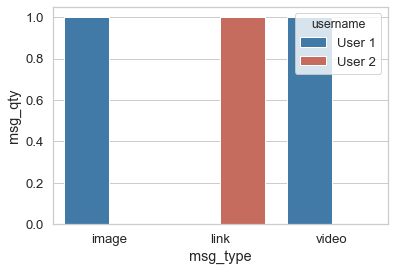

In [188]:
sns.barplot(data=viz_messages_summary[viz_messages_summary["msg_type"]!="text"], x="msg_type", y="msg_qty", hue="username")

**Visualization 2:**<br>
The `timeseries` dataframe can be used to create a 'run chart' of day-by-day message counts, separated by user. Given the expected noisiness of the data if done over a long time frame, the vizualization is meant as a primarily birds-eye view of the data (as well as being able to highlight noteable areas of interest).

In [189]:
# Unstack and reindex timeseries dataframe to make a plot-friendly version
viz_timeseries = timeseries.drop(columns="total").unstack().rename("msg_qty").reset_index()
viz_timeseries.head()

,username,msg_type,date_time,msg_qty
0,User 1,image,2020-02-28 00:00:00-05:00,0.0
1,User 1,image,2020-02-29 00:00:00-05:00,0.0
2,User 1,image,2020-03-01 00:00:00-05:00,0.0
3,User 1,image,2020-03-02 00:00:00-05:00,0.0
4,User 1,image,2020-03-03 00:00:00-05:00,0.0


In [190]:
# Define the limits for the plot's x-axis
time_start = viz_timeseries.iloc[0]['date_time'].replace(day=1) - dt.timedelta(days=1)                             # Last day of previous month
time_end = viz_timeseries.iloc[-1]['date_time'].replace(day=1, month=viz_timeseries.iloc[-1]['date_time'].month+1) # First day of next month

In [191]:
# Helper function to define tick positions and tick labels for the additional 'year' axis included in the plot
def find_xaxis_params(axis, time_start, time_end):
    """
    Input:     axis:             Matplotlib axis object - the 'original' x-axis of the plot with ticks defined outside the function 
    
               time_start:       Starting datetime object of the x-axis plot. Defined as:
                                    - First chronological datetime from the viz_timeseries dataframe
                                    - Day set to 1st of that month
                                    - Moved back 1 day (i.e, last day of the previous month)
                                    
               time_end:         Ending datetime object of the x-axis plot. Defined as:
                                    - Last chronological datetime from the viz_timeseries dataframe
                                    - Day set to 1st of that month
                                    - Moved forward 1 month (i.e, first day of the next month)
    
    Output:    Tuple of the following:
               year_ticks:       List of relative positions (0 - 1) corresponding to each tick where a year begins
               year_labels:      List of strings with the name of the year
               year_label_ticks: List of relative positions (0 - 1) corresponding to the tick where the year label is drawn
    """
    
    # Define the relative positions (from 0 - 1) of each tick in the x-axis
    x_min, x_max = axis.get_xlim()
    ticks = [(tick - x_min)/(x_max - x_min) for tick in axis.get_xticks()]
    
    # Get datetime which matches the first displayed label on the x-axis
    time_start_label = time_start + dt.timedelta(days=1)
    
    # Get datetime which matches the last displayed label on the x-axis
    time_end_label = time_end
    
    
    # Define initial values for our outputs and helper variable 'year_ticks_index'
    year_ticks = [ticks[0]]
    year_ticks_index = [0]
    year_labels = [time_start_label.strftime("%Y")]
    year_label_ticks = []
    prev_label = time_start_label
    
    # Loop through each tick (skipping first)
    for idx, tick in enumerate(ticks[1:], start=1):
        curr_label = prev_label + relativedelta(months=1)

        # If the year has changed, store the value and index of that particular tick. Also capture the year name
        if (curr_label.year != prev_label.year):
            year_ticks.append(tick)
            year_ticks_index.append(idx)
            year_labels.append(curr_label.strftime("%Y"))

        prev_label = curr_label

        
    # Add the value and index of the last tick to their respective lists
    year_ticks.append(ticks[-1])
    year_ticks_index.append(len(ticks)-1)
    
    
    # Loop through each year-tick (ending before the last element since we are forward-windowing in this loop)
    for idx, tick in enumerate(year_ticks_index[:-1]):

        # Calculate the delta between the current year-tick and next year-tick
        delta = year_ticks_index[idx+1] - year_ticks_index[idx]
        i = year_ticks_index[idx] + int(delta // 2)
        j = i + 1
        
        # If delta is even, use middle tick between the year-ticks. Else average between the middle ticks.
        if (delta % 2 == 0):
            year_label_ticks.append(ticks[i])
        else:
            year_label_ticks.append((ticks[i]+ticks[j]) / 2)

    return (year_ticks, year_labels, year_label_ticks)


In [192]:
# Import from mpl_toolkits to handle duplicate ('parasite') axes on the original ('host') plot
from mpl_toolkits.axes_grid.parasite_axes import SubplotHost

In [193]:
# Select colour palette for plotting
palette_RdBu = sns.color_palette("RdBu", 19)
palette_CustPair = [palette_RdBu[16], palette_RdBu[3]]

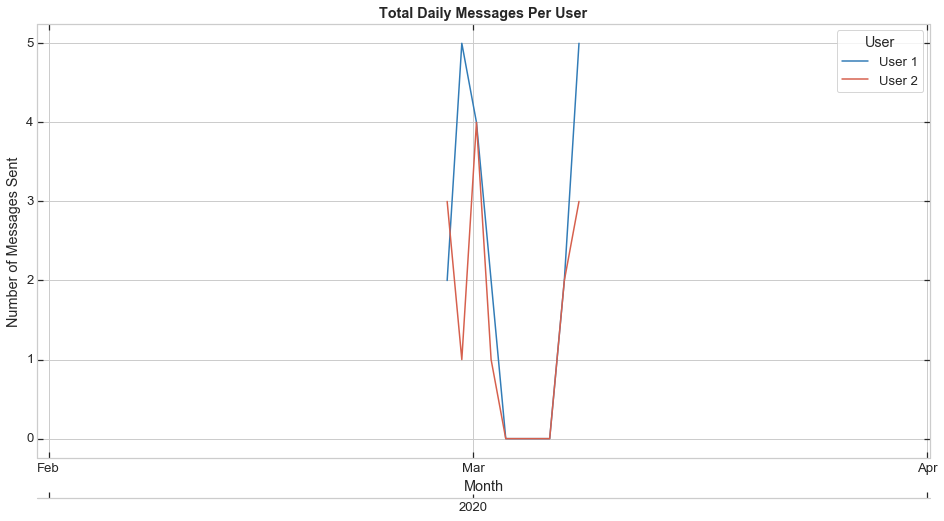

In [194]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(palette_CustPair)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Set figure size, first (host) axes, and plot using Seaborn
fig = plt.figure(figsize=(16,8))
ax1 = SubplotHost(fig, 111)
fig.add_subplot(ax1)
ax1 = sns.lineplot(data=viz_timeseries, x="date_time", y="msg_qty", hue="username", ci=None, estimator='sum')

# Define by-month ticks on x-axis, define formatting, and define limits
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(left=time_start, right=time_end)

# Use helper function to define tick parameters for the second 'parasite' axis
year_ticks, year_labels, year_label_ticks = find_xaxis_params(ax1, time_start, time_end)

# Create second axis, position, and modify visibility
ax2 = ax1.twiny()
offset = 0, -40    # Hardcoded position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.axis["top"].set_visible(False)
ax1.axis["top"].set_visible(True)

# Define / draw second axis using params
ax2.set_xticks(year_ticks)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(year_label_ticks))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(year_labels))

# Formatting axes elements and titles
ax1.set_title("Total Daily Messages Per User", weight="bold")
ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Messages Sent")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=labels[1:], title="User")


**Visualization 3:**<br>
- Creating 'by user' visualizations require us to have access to the individual tokens in `messages[text_processed]`. We can explode out each token to a new row and preserve usernames (in a new dataframe) as follows:

In [195]:
text_expanded = messages[['username','text_processed']].explode('text_processed').dropna()
text_expanded.head()

,username,text_processed
0,User 1,outside
0,User 1,came
0,User 1,occasional
0,User 1,cry
0,User 1,night-bird


We need to pivot this data such that we obtain rows for counts of each unique word, broken down per user. This can be done as follows:

In [196]:
# Pivot
text_expanded_by_user = text_expanded.pivot_table(text_expanded, 
                                                  index='text_processed', 
                                                  columns='username', 
                                                  aggfunc=len).fillna(0)

# Create and populate a 'total' column
text_expanded_by_user['total'] = text_expanded_by_user.sum(axis=1)

# Sort by most common words
text_expanded_by_user.sort_values(by='total', ascending=False, inplace=True)
        
# Re-index dataframe and fix column naming
text_expanded_by_user = text_expanded_by_user.reset_index()
text_expanded_by_user.rename_axis(None, axis=1, inplace=True)

text_expanded_by_user.head(15)

,text_processed,User 1,User 2,total
0,lmao,4.0,1.0,5.0
1,hahaha,3.0,1.0,4.0
2,see,2.0,1.0,3.0
3,sound,2.0,1.0,3.0
4,struck,2.0,1.0,3.0
5,heard,1.0,2.0,3.0
6,gentle,1.0,1.0,2.0
7,smell,1.0,1.0,2.0
8,could,1.0,1.0,2.0
9,hour,1.0,1.0,2.0


A horizontal comparative barplot was used to visualize this data. [This post](https://stackoverflow.com/questions/27694221/using-python-libraries-to-plot-two-horizontal-bar-charts-sharing-same-y-axis) and [this post](https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values) provided the methodology and functions to create the non-standard visualization below.

In [197]:
# Optional plotting function to annotate barplot with bar values
def show_values_on_bars(axs, h_v="v", space=0.4):
    """
    Input:     axs:      Matplotlib axis object
               h_v:      Whether the barplot is horizontal or vertical. 
                         "h" represents the horizontal barplot, "v" represents the vertical barplot.
               space:    The space between value text and the top edge of the bar. Only works for horizontal mode.
               
    Output:    ax.text(): Annotates figure at the calculated x and y co-ordinates with the bar value
    """
    
    # Set this to shift the y-axis alignment of the bar value text
    align_factor = 0.6
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize="small") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() * align_factor
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="center", fontsize="small")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

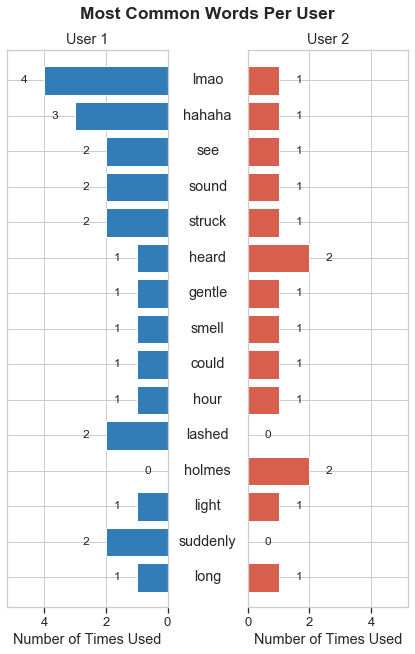

In [198]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(palette_CustPair)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Select the number of words/emojis to be shown in the visualization
max_items = 15

# Extract relevant data from dataframe into lists
y_words = text_expanded_by_user.iloc[0:max_items]["text_processed"].tolist()
ax0_values = text_expanded_by_user.iloc[0:max_items, 1].tolist()
ax1_values = text_expanded_by_user.iloc[0:max_items, 2].tolist()
user_names = text_expanded_by_user.columns.values[1:3].tolist()

# Define values for y-axis ticks and define x-axis limit
y = np.arange(len(y_words))
max_itemcount = max(ax0_values + ax1_values) * 1.3


# Plot figure to specified size, with 2 sublpots sharing a common y-axis
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,10))
axes[0].barh(y_words, ax0_values, align='center', color=palette_CustPair[0])
axes[0].set_title(user_names[0])
axes[0].set_xlim(0, max_itemcount)
axes[0].set_xlabel("Number of Times Used")
axes[0].tick_params(axis='x', which='major', bottom=True)

axes[1].barh(y_words, ax1_values, align='center', color=palette_CustPair[1])
axes[1].set_title(user_names[1])
axes[1].set_xlim(0, max_itemcount)
axes[1].set_xlabel("Number of Times Used")
axes[1].tick_params(axis='x', which='major', bottom=True)

# Invert y-axis and left-side x-axis. Remove existing y-axis labels
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].set(yticks=y_words, yticklabels=[])

# Add y-axis labels in desired location and text/emoji orientation
for yloc, label in zip(y, y_words):
    axes[0].annotate(label, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')
    
# OPTIONAL: Add values to each bar using helper function
show_values_on_bars(axes, "h", max_itemcount/8)

# Add margins to top/bottom of graph
for ax in axes.flat:
    ax.margins(0.03)

# Add common figure title and adjust subplot positions as required    
fig.suptitle("Most Common Words Per User", weight="bold").set_y(0.91)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)

- Finding the longest used word requires a bit of additional manipulation of the `text_expanded_by_user` dataset. The wordlist includes url text so we need to lookup each word in an English language dictionary (`words` from `nltk.corpus` in this case - it isn't the best wordlist but it probably isn't worth the effort to import a large library for the sake of a one-line visualization).

In [199]:
from nltk.corpus import words
wordset = set(words.words())

In [200]:
# Add a column to capture word lengths (will be used later)
text_expanded_by_user['word_len'] = text_expanded_by_user['text_processed'].apply(len)

# Add a column to determine word presence in English
text_expanded_by_user["english_word"] = text_expanded_by_user["text_processed"].apply(lambda x: x in wordset)

# Sort by word length and English-only words, and select longest word
text_expanded_by_user[text_expanded_by_user['english_word']].sort_values(by='word_len', ascending=False).iloc[0]

text_processed    immediately
User 1                      0
User 2                      1
total                       1
word_len                   11
english_word             True
Name: 108, dtype: object

**Visualization 4:**<br>
We can repeat the process above to obtain a similar dataframe for emojis. **Note:** Need to'de-emojize' before pivoting, since many identical emojis were unnecessarily represented differently in unicode. To display as emojis in visualizations, must 're-emojize' the emojis.

In [201]:
emoji_expanded = messages[['username','emojis']].explode('emojis').dropna()
emoji_expanded.head()

,username,emojis
1,User 2,😯
1,User 2,😯
1,User 2,😯
4,User 1,😯
4,User 1,☺


In [202]:
# De-emoji in-progress dataframe
emoji_expanded['emojis'] = emoji_expanded['emojis'].apply(emoji.demojize)

# Pivot
emoji_expanded_by_user = emoji_expanded.pivot_table(emoji_expanded, 
                                                  index='emojis', 
                                                  columns='username', 
                                                  aggfunc=len).fillna(0)

# Create and populate a 'total' column
emoji_expanded_by_user['total'] = emoji_expanded_by_user.sum(axis=1)

# Sort by most common emojis
emoji_expanded_by_user.sort_values(by='total', ascending=False, inplace=True)

# Re-index dataframe and fix column naming
emoji_expanded_by_user = emoji_expanded_by_user.reset_index()
emoji_expanded_by_user.rename_axis(None, axis=1, inplace=True)

# 'Re-emoji' in a separate column
emoji_expanded_by_user['emojis_disp'] = emoji_expanded_by_user['emojis'].apply(emoji.emojize)

emoji_expanded_by_user.head(10)

,emojis,User 1,User 2,total,emojis_disp
0,:hushed_face:,7.0,4.0,11.0,😯
1,:loudly_crying_face:,0.0,7.0,7.0,😭
2,:eyes:,2.0,0.0,2.0,👀
3,:grinning_squinting_face:,2.0,0.0,2.0,😆
4,:smiling_face:,2.0,0.0,2.0,☺
5,:frowning_face:,1.0,0.0,1.0,☹
6,:grinning_face_with_smiling_eyes:,0.0,1.0,1.0,😄


The same horizontal barplot visualization used in **Vizualization 3** can be modified to display emoji usage statistics. This required additional work in order to implement emoji images as y-axis labels. [Twemoji](https://github.com/twitter/twemoji/tree/gh-pages) was used as an open-source image repository and [this link](https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html) provides some guidance for annotating using images.
<br><br> 
**Note:** Matplotlib unfortunately scales PNG files horribly when drawing figures. To rectify this, I was able to leverage the [CairoSVG](https://cairosvg.org/documentation/) library to draw the Twemoji source SVGs into PNGs of an appropriate size, avoiding any matplotlib scaling. Unfortunately, the actual installation of CairoSVG was a bit complicated (it was installed as part of another library called [WeasyPrint](https://weasyprint.readthedocs.io/en/latest/install.html)), so I have chosen to do this SVG -> PNG conversion offline. I have provided the converted 24x24 pixel PNGs in the repo, as well as the `svg_to_png.py` script used to do the conversion if you wish to re-draw the images to a different size. However, this is fair warning that without re-drawing the images, *YMMV* when trying to editing dimensions of the visualization below.

In [203]:
# Function to populate filepaths for each emoji in dataframe to the Twemoji library
def utf8_to_filepath(emoji_utf8):
    """
    Input:     emoji_utf8: Emoji in UTF-8 encoding
    Output:    relative file path pointing from this notebook's current directory to the appropriate Twemoji .png file
    """
    folderpath = os.path.join("twemoji-gh-pages", "emojilib", "png")
    emoji_codepoint = str(hex(ord(emoji_utf8)))[2:]
    
    return os.path.join(folderpath, emoji_codepoint + ".png")


In [204]:
utf8_to_filepath(emoji_expanded_by_user['emojis_disp'].iloc[0])

'twemoji-gh-pages\\emojilib\\png\\1f62f.png'

In [205]:
# Apply the function to the emoji_expanded_by_user dataframe
emoji_expanded_by_user["img_path"] = emoji_expanded_by_user["emojis_disp"].apply(utf8_to_filepath)
emoji_expanded_by_user.head()

,emojis,User 1,User 2,total,emojis_disp,img_path
0,:hushed_face:,7.0,4.0,11.0,😯,twemoji-gh-pages\emojilib\png\1f62f.png
1,:loudly_crying_face:,0.0,7.0,7.0,😭,twemoji-gh-pages\emojilib\png\1f62d.png
2,:eyes:,2.0,0.0,2.0,👀,twemoji-gh-pages\emojilib\png\1f440.png
3,:grinning_squinting_face:,2.0,0.0,2.0,😆,twemoji-gh-pages\emojilib\png\1f606.png
4,:smiling_face:,2.0,0.0,2.0,☺,twemoji-gh-pages\emojilib\png\263a.png


In [206]:
# Matplotlib import for drawing images in annotations
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
#from matplotlib.cbook import get_sample_data

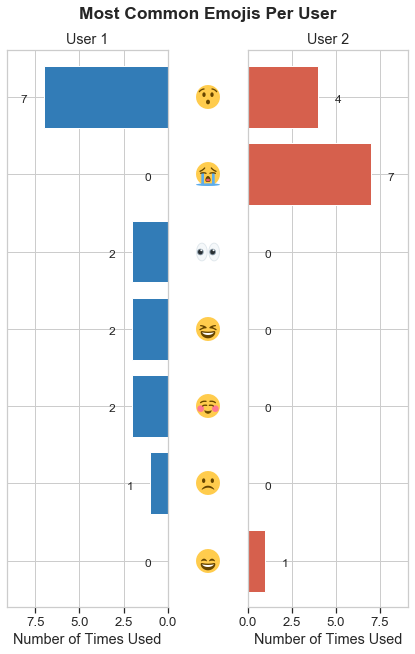

In [207]:
# Define plot style, palette and font scaling
sns.set_style('whitegrid')
sns.set_palette(palette_CustPair)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Select the number of words/emojis to be shown in the visualization
max_items = 15

# Extract relevant data from dataframe into lists
y_emojis = emoji_expanded_by_user.iloc[0:max_items]["img_path"].tolist()
ax0_values = emoji_expanded_by_user.iloc[0:max_items, 1].tolist()
ax1_values = emoji_expanded_by_user.iloc[0:max_items, 2].tolist()
user_names = emoji_expanded_by_user.columns.values[1:3].tolist()

# Define values for y-axis ticks and define x-axis limit
y = np.arange(len(y_emojis))
max_itemcount = max(ax0_values + ax1_values) * 1.3


# Plot figure to specified size, with 2 sublpots sharing a common y-axis
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,10))
axes[0].barh(y_emojis, ax0_values, align='center', color=palette_CustPair[0])
axes[0].set_title(user_names[0])
axes[0].set_xlim(0, max_itemcount)
axes[0].set_xlabel("Number of Times Used")
axes[0].tick_params(axis='x', which='major', bottom=True)

axes[1].barh(y_emojis, ax1_values, align='center', color=palette_CustPair[1])
axes[1].set_title(user_names[1])
axes[1].set_xlim(0, max_itemcount)
axes[1].set_xlabel("Number of Times Used")
axes[1].tick_params(axis='x', which='major', bottom=True)

# Invert y-axis and left-side x-axis. Remove existing y-axis labels
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].set(yticks=y_emojis, yticklabels=[])


# Add y-axis labels in desired location and text/emoji orientation
for yloc, emoji_path in zip(y, y_emojis):
    
    # Read in current image
    arr_img = plt.imread(emoji_path, format='png')

    # Define image parameters and axes
    imagebox = OffsetImage(arr_img, zoom=1)
    imagebox.image.axes = ax

    # Define annotation parameters for drawing the image in the correct location (with ticks)
    ab = AnnotationBbox(imagebox, (0.5, yloc), 
                        xybox=(0, 0), 
                        xycoords=('figure fraction', 'data'), 
                        boxcoords="offset points", 
                        bboxprops=dict(edgecolor=None), 
                        pad=0.25)

    # Add the image annotation to the figure
    axes[0].add_artist(ab)
    
    
# OPTIONAL: Add values to each bar using helper function
show_values_on_bars(axes, "h", max_itemcount/8)

# Add margins to top/bottom of graph
for ax in axes.flat:
    ax.margins(0.03)

# Add common figure title and adjust subplot positions as required    
fig.suptitle("Most Common Emojis Per User", weight="bold").set_y(0.91)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.subplots_adjust(wspace=0.5)


**Visualization 5:**<br>
To get a day-of-the-week breakdown of messaging data, we'll need to adopt a similar resampling approach as the `timeseries` dataframe, but with a bit more creativity to give the hour-by-hour granularity desired.

In [208]:
# Resample the timeseries_raw dataframe used earlier by hour.
timeseries_weekday_hour = timeseries_raw.resample('H').sum()
#timeseries_weekday['total'] = timeseries_weekday.sum(axis=1)
#timeseries.sort_values(by='total', ascending=False, inplace=True)
timeseries_weekday_hour.head()

username                  User 1            User 2     
msg_type                   image text video   link text
date_time                                              
2020-02-28 02:00:00-05:00    0.0  2.0   0.0    0.0  3.0
2020-02-28 03:00:00-05:00    0.0  0.0   0.0    0.0  0.0
2020-02-28 04:00:00-05:00    0.0  0.0   0.0    0.0  0.0
2020-02-28 05:00:00-05:00    0.0  0.0   0.0    0.0  0.0
2020-02-28 06:00:00-05:00    0.0  0.0   0.0    0.0  0.0

We need to reindex the dataframe to a 'weekday-hour' multindex format. Let's start by generating these columns from the datetime object found in the index, using a helper function.

In [209]:
# Function to extract weekday (text) and hour (int) from a datetime object.
def extract_weekday_hour(datetime_obj):
    """
    Input:  Python Datetime object            
    Output: Tuple: (String with weekday of datetime object, Int with hour of datetime object (24h))
    """
    return (datetime_obj.strftime('%A'), datetime_obj.hour)

In [210]:
# Apply function to the dataframe:
timeseries_weekday_hour['weekday'], timeseries_weekday_hour['hour'] = zip(*timeseries_weekday_hour.index.map(extract_weekday_hour))
timeseries_weekday_hour.head(24)

username                  User 1            User 2        weekday hour
msg_type                   image text video   link text               
date_time                                                             
2020-02-28 02:00:00-05:00    0.0  2.0   0.0    0.0  3.0    Friday    2
2020-02-28 03:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    3
2020-02-28 04:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    4
2020-02-28 05:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    5
2020-02-28 06:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    6
2020-02-28 07:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    7
2020-02-28 08:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    8
2020-02-28 09:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday    9
2020-02-28 10:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   10
2020-02-28 11:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   11
2020-02-28 12:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   12
2020-02-28 13:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   13
2020-02-28 14:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   14
2020-02-28 15:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   15
2020-02-28 16:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   16
2020-02-28 17:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   17
2020-02-28 18:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   18
2020-02-28 19:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   19
2020-02-28 20:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   20
2020-02-28 21:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   21
2020-02-28 22:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   22
2020-02-28 23:00:00-05:00    0.0  0.0   0.0    0.0  0.0    Friday   23
2020-02-29 00:00:00-05:00    0.0  0.0   0.0    0.0  0.0  Saturday    0
2020-02-29 01:00:00-05:00    0.0  0.0   0.0    0.0  0.0  Saturday    1

Now we are ready to reindex the dataframe, and then aggregate it (using mean and unstack+stack). We can also create a total column as required.

In [211]:
# Reindex
timeseries_weekday_hour.set_index(['weekday', 'hour'], inplace=True)

# Aggregate
timeseries_weekday_hour = timeseries_weekday_hour.mean(level=[0,1]).unstack().stack(dropna=False)

# Add total column
timeseries_weekday_hour['total'] = timeseries_weekday_hour.sum(axis=1)

timeseries_weekday_hour.head(24)

username     User 1            User 2      total
msg_type      image text video   link text      
weekday hour                                    
Friday  0       0.0  0.0   0.0    0.0  0.0   0.0
        1       0.0  0.0   0.0    0.0  0.0   0.0
        2       0.0  1.0   0.0    0.0  1.5   2.5
        3       0.0  0.0   0.0    0.0  0.0   0.0
        4       0.0  0.0   0.0    0.0  0.0   0.0
        5       0.0  0.0   0.0    0.0  0.0   0.0
        6       0.0  0.0   0.0    0.0  0.0   0.0
        7       0.0  0.0   0.0    0.0  0.0   0.0
        8       0.0  0.0   0.0    0.0  0.0   0.0
        9       0.0  0.0   0.0    0.0  0.0   0.0
        10      0.0  0.0   0.0    0.0  0.0   0.0
        11      0.0  0.0   0.0    0.0  0.0   0.0
        12      0.0  0.0   0.0    0.0  0.0   0.0
        13      0.0  0.0   0.0    0.0  0.0   0.0
        14      0.0  0.0   0.0    0.0  0.0   0.0
        15      0.0  0.0   0.0    0.0  0.0   0.0
        16      0.0  0.0   0.0    0.0  0.0   0.0
        17      0.0  0.0   0.0    0.0  0.0   0.0
        18      0.0  0.0   0.0    0.0  0.0   0.0
        19      0.0  0.0   0.0    0.0  0.0   0.0
        20      0.0  0.0   0.0    0.0  0.0   0.0
        21      0.0  0.0   0.0    0.0  0.0   0.0
        22      0.0  0.0   0.0    0.0  0.0   0.0
        23      0.0  0.0   0.0    0.0  0.0   0.0

**Visualization 6:**<br>
To find the longest consecutive gap (in days/hours) between messages, we can leverage Pandas' built-in [df.diff()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html) method.

In [212]:
# Extract non-aggregated datetime and message type fields directly from 'messages' dataframe
timeseries_deltas = pd.DataFrame(messages[['date_time', 'msg_type']])

# Calculate time deltas
timeseries_deltas['deltas'] = timeseries_deltas['date_time'].diff().fillna(pd.Timedelta(seconds=0))

timeseries_deltas.head()

,date_time,msg_type,deltas
0,2020-02-28 02:55:53-05:00,text,00:00:00
1,2020-02-28 02:55:53-05:00,text,00:00:00
2,2020-02-28 02:56:07-05:00,text,00:00:14
3,2020-02-28 02:56:08-05:00,text,00:00:01
4,2020-02-28 02:56:27-05:00,text,00:00:19


In [213]:
# Find top 5 largest gaps between messages (any message type)
timeseries_deltas.nlargest(5, 'deltas')

,date_time,msg_type,deltas
22,2020-03-07 00:45:42-05:00,text,4 days 02:25:10
19,2020-03-02 22:10:29-05:00,text,1 days 17:00:21
26,2020-03-08 17:10:08-04:00,text,1 days 16:00:12
5,2020-02-29 17:56:40-05:00,text,1 days 15:00:13
11,2020-03-01 03:02:42-05:00,text,0 days 08:47:30


In [214]:
# Find top 5 largest gaps between messages (text messages)
timeseries_deltas[timeseries_deltas['msg_type']=='text'].nlargest(5, 'deltas')

,date_time,msg_type,deltas
22,2020-03-07 00:45:42-05:00,text,4 days 02:25:10
19,2020-03-02 22:10:29-05:00,text,1 days 17:00:21
26,2020-03-08 17:10:08-04:00,text,1 days 16:00:12
5,2020-02-29 17:56:40-05:00,text,1 days 15:00:13
11,2020-03-01 03:02:42-05:00,text,0 days 08:47:30
